# RNA-seq - Differential Expression Analysis of treated time points compared to untreated control
- goal: DEGs over time and treatment
- input: filtered raw counts
- output: DEA results, enrichments

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(limma)
library(ggplot2, quietly=T)
library(data.table, quietly=T)
library(pheatmap, quietly=T)
library(GGally)
library('biomaRt')
library(edgeR)
options(stringsAsFactors=F)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [3]:
#### utility functions

source("./src/utils_Enrichr.R")

# Make a matrix out of a data.table
toMT <- function(dt, row, col, val){
  retDT <- dcast.data.table(dt, get(row) ~ get(col), value.var=val)
  retMT <- as.matrix(retDT[,-"row"])
  row.names(retMT) <- retDT$row
  return(retMT)
}

# Remove plots from device. Useful for pheatmap (and others?)
cleanDev <- function(n=2){sapply(1:n, function(i){try({dev.off()}, silent=TRUE)}); return(TRUE)}

# Write tsv table
write.tsv <- function(...){
  write.table(..., sep="\t", row.names=FALSE, quote=FALSE);
}

# Rotate x-axis in ggplot
xRot <- function(){theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))}

Loading required package: enrichR

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [4]:
# configs
data_path <- file.path('results','RNA','counts')
metadata_path <- file.path('metadata','RNA_sample_metadata.csv')
results_path <- file.path('results','RNA','DEA')

In [5]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# Load data

In [9]:
# load annotations
annot <- read.csv(file=metadata_path, row.names=1)
dim(annot)
head(annot)

[1] 66 10

,library,timepoint.after.thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,organism,bio.replicate,experiment_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
RNA_PT76_R1_C_albicans_2h,Quant-seq,d010,BMDM,C_albicans,2h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R1_C_albicans_24h,Quant-seq,d010,BMDM,C_albicans,24h,PT62_c,female,mouse,R1,PT82
RNA_PT76_R1_C_albicans_4h,Quant-seq,d010,BMDM,C_albicans,4h,PT62_c,female,mouse,R1,PT76
RNA_PT76_R1_C_albicans_6h,Quant-seq,d010,BMDM,C_albicans,6h,PT62_c,female,mouse,R1,PT76
RNA_PT82_R1_C_albicans_8h,Quant-seq,d010,BMDM,C_albicans,8h,PT62_c,female,mouse,R1,PT82
RNA_PT76_R1_untreated_0h,Quant-seq,d010,BMDM,untreated,0h,PT62_c,female,mouse,R1,PT76


In [10]:
# rename columns
names(annot)[names(annot) == 'Treatment'] <- 'treatment'
names(annot)[names(annot) == 'Treatment_time'] <- 'time'
names(annot)[names(annot) == 'experiment_id'] <- 'experiment'
annot$sample_name <- rownames(annot)

In [11]:
# load data -> without symbols, because symbols have duplicates
data <- read.csv(file=file.path(data_path,'all_filtered.tsv'), row.names=1, sep='\t')
dim(data)
head(data)

[1] 12729    64

,RNA_PT82_R1_LO28_24h,RNA_PT82_R2_LO28_24h,RNA_PT76_R2_LCMV_Cl13_4h,RNA_PT76_R1_LO28_6h,RNA_PT82_R2_untreated_24h,RNA_PT82_R2_IFN_beta_24h,RNA_PT76_R1_LCMV_Cl13_2h,RNA_PT76_R1_LPS_6h,RNA_PT76_R1_C_albicans_4h,RNA_PT82_R2_IFN_gamma_24h,⋯,RNA_PT76_R1_LCMV_Cl13_4h,RNA_PT76_R2_C_albicans_6h,RNA_PT82_R1_LPS_8h,RNA_PT76_R2_LPS_2h,RNA_PT82_R2_IFN_beta_8h,RNA_PT82_R2_LO28_8h,RNA_PT82_R1_IFN_beta_8h,RNA_PT76_R2_LPS_4h,RNA_PT76_R1_IFN_beta_6h,RNA_PT82_R2_LPS_8h
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000098104,0,1,5,3,4,4,11,1,0,2,⋯,2,2,9,6,2,0,4,3,6,3
ENSMUSG00000033845,52,56,190,85,135,111,194,119,201,148,⋯,238,221,179,210,140,109,112,166,150,189
ENSMUSG00000025903,56,60,32,68,104,84,82,47,106,93,⋯,184,109,61,120,114,95,103,98,164,125
ENSMUSG00000033813,21,40,16,55,53,62,20,62,39,60,⋯,82,54,51,48,153,110,104,72,146,119
ENSMUSG00000033793,381,365,45,152,247,218,90,69,309,171,⋯,335,294,212,217,323,353,174,251,290,416
ENSMUSG00000025907,217,218,297,188,302,305,245,260,225,249,⋯,324,325,466,491,360,300,315,325,257,529


In [12]:
annot <- annot[colnames(data),]

In [13]:
# load gene annotations
RNA.gmap <- read.csv(file=file.path(data_path, paste0("gene_annotation.tsv")), sep='\t')
dim(RNA.gmap)
head(RNA.gmap)

[1] 55487     9

,ensembl_gene_id,version,source,external_gene_name,external_gene_source,description,gene_biotype,length,gc
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,ENSMUSG00000000194,13,ensembl_havana,Gpr107,MGI Symbol,G protein-coupled receptor 107 [Source:MGI Symbol;Acc:MGI:2139054],protein_coding,12766,0.4945950
2,ENSMUSG00000000247,11,ensembl_havana,Lhx2,MGI Symbol,LIM homeobox protein 2 [Source:MGI Symbol;Acc:MGI:96785],protein_coding,4393,0.5970863
3,ENSMUSG00000000544,14,ensembl_havana,Gpa33,MGI Symbol,glycoprotein A33 (transmembrane) [Source:MGI Symbol;Acc:MGI:1891703],protein_coding,2742,0.5309993
4,ENSMUSG00000000817,10,ensembl_havana,Fasl,MGI Symbol,"Fas ligand (TNF superfamily, member 6) [Source:MGI Symbol;Acc:MGI:99255]",protein_coding,1937,0.4305627
5,ENSMUSG00000000889,8,ensembl_havana,Dbh,MGI Symbol,dopamine beta hydroxylase [Source:MGI Symbol;Acc:MGI:94864],protein_coding,2692,0.5549777
6,ENSMUSG00000001138,13,ensembl_havana,Cnnm3,MGI Symbol,cyclin M3 [Source:MGI Symbol;Acc:MGI:2151055],protein_coding,6420,0.5610592


# DEA (on filtered matrix)

In [11]:
# PCA, Correlation Heatmap and DEA (<10 DEGs) showed that there is NO big difference between untreated 0h, 8h, and 24h 
# -> no significant batch effect -> combine them in one untreated_0h group as control for the DEA, but still account for it in the linear model
annot[annot$treatment=='untreated','time'] <- '0h'

In [12]:
voomFile <- file.path(results_path, "VoomAnalysis.RData")

annData <- data.frame(group=with(annot, paste(treatment, time, sep="_")), row.names=annot$sample_name)
annData$group <- factor(annData$group, levels=unique(c("untreated_0h", annData$group[annData$group != "untreated_0h"])))
# experiment variable to estimate batch effect
annData$experiment <- factor(annot[rownames(annData), 'experiment'], levels=c("PT76", "PT82"))
# model group (treatment+time) and batch (experiment)
desMat <- model.matrix(~ group + experiment, data=annData)
cleanDev(); 
jpeg(file.path(results_path, "Voom.jpg"))
voomRes <- voom(data[,row.names(annData)], design = desMat,plot=TRUE)
dev.off()

fit <- lmFit(voomRes, desMat)
fit <- eBayes(fit)
coefs <- grep("group", colnames(coef(fit)), value=T)
coefx <- coefs[1]
res <- data.table()
for(coefx in coefs){
    res <- rbind(res, data.table(group=gsub("group", "", coefx), topTable(fit=fit,coef=coefx, number=nrow(voomRes$E)), keep.rownames=T))
}

write.table(voomRes$E, sep=",", quote=F, row.names=T, file=file.path(results_path, paste0("VoomTransformed.Counts.csv")))
save(res, voomRes, file=voomFile)

# res.sig <- res[adj.P.Val < 0.05 & AveExpr > 1] # filter significant genes and average expression per group
res.sig <- res[adj.P.Val < 0.05] # filter only significant genes
res.sig[,direction := ifelse(logFC > 0, "up", "down")]
res.sig <- merge(RNA.gmap, res.sig, by.y="rn", by.x="ensembl_gene_id")
write.table(res.sig, file.path(results_path, "Significant.genes.tsv"),sep="\t", row.names=FALSE, quote=FALSE)

[1] TRUE

null device 
          1

In [13]:
# save DEA results per condition
for (treatment in unique(annot$treatment)){
    write.table(res[grepl(treatment, res$group),], file.path(results_path, paste0('DEA_',treatment,".tsv")) ,sep="\t", row.names=FALSE, quote=FALSE)
}

In [14]:
# plot fitted mean/variance relationship
pdf(file.path(results_path, "Voom_fitted.pdf"))
plotSA(fit)
dev.off()

png 
  2

In [30]:
# Correlation of log fold changes ALL GENES -----------------------------------------
logfcMT <- toMT(dt=res, row="rn", col="group", val="logFC")
cMT <- cor(logfcMT)
diag(cMT) <- NA
cleanDev();
pdf(file.path(results_path, "Correlations_logFC.pdf"),w=8,h=8)
pheatmap(cMT)
dev.off()

write.table(cMT, file.path(results_path, paste0('DEA_LFC_correltation.csv')) ,sep=",", row.names=TRUE, quote=FALSE)

[1] TRUE

null device 
          1

In [16]:
# Correlation of log fold changes Only significant genes (by adj.pvalue < 0.05)
cMT <- cor(logfcMT[unique(res.sig$ensembl_gene_id),])
diag(cMT) <- NA
cleanDev(); pdf(file.path(results_path, "Correlations_logFC_Significant.pdf"),w=8,h=8)
pheatmap(cMT)
dev.off()

[1] TRUE

null device 
          1

In [17]:
# # Plot pairs ------------------------------------------------------
# logfcMT <- toMT(dt=res[grepl("_2h$", group)], row="rn", col="group", val="logFC")[unique(res.sig$ensembl_gene_id),]
# my_fun <- function(data=data, mapping=mapping, ...){
#   ggplot(data=data, mapping=mapping) + stat_binhex(aes(fill=log10(..count..)))
# }

# p <- ggpairs(data.table(logfcMT), lower=list(continuous=my_fun)) + theme_bw(12)
# ggsave(file.path(results_path,  "Pairs.pdf"), w=10,h=10, plot=p)

# diff <- apply(combn(ncol(logfcMT), 2), 2, function(x){ logfcMT[,x[1]] - logfcMT[,x[2]] })
# colnames(diff) <- apply(combn(ncol(logfcMT), 2), 2, function(x){ paste(colnames(logfcMT)[x], collapse="_vs_") })
# diff <- data.table(diff, keep.rownames=T)

# pairs.summary <- merge(RNA.gmap, diff, by.x="ensembl_gene_id", by.y="rn")

# pairs.summary <- merge(pairs.summary, data.table(logfcMT, keep.rownames=T), by.x="ensembl_gene_id", by.y="rn")

# write.tsv(pairs.summary, file.path(results_path,  "Pairs_Differences.tsv"))

[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_5' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_6' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_7' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_8' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_9' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_10' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_11' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

Warning message in dir.create(outCl):
“'results/RNA/DEA/Pairs_Clusters_HM_12' already exists”


[1] "Enrichment of list: 1"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 2"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: 3"
Uploading data to Enrichr... Done.
  Querying BioPlanet_2019... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO

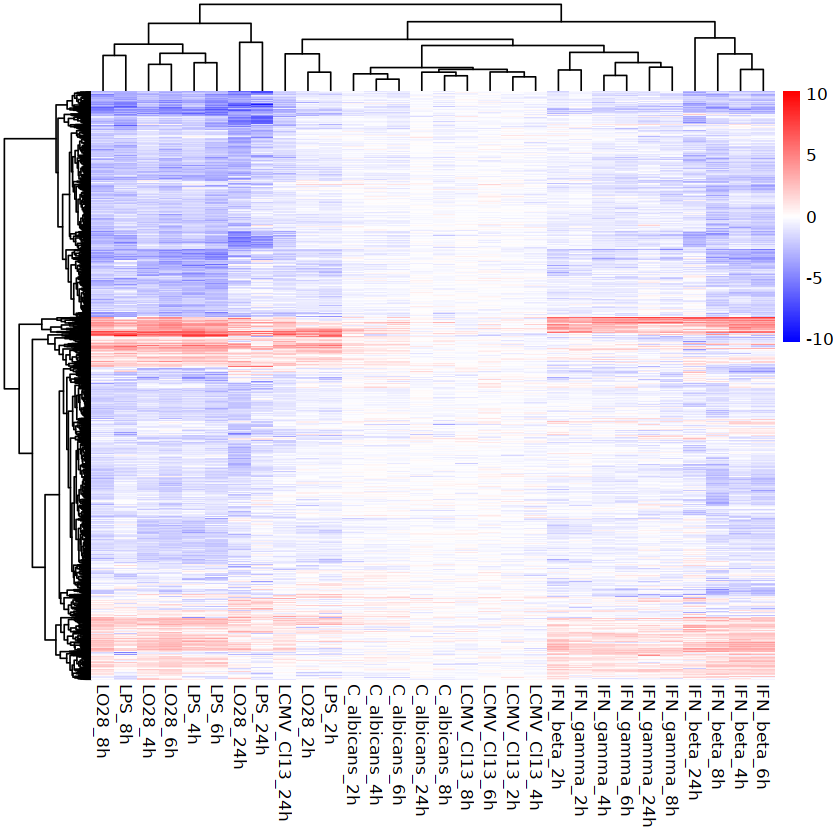

In [30]:
# clustered Heatmap of changes by LFC of significant genes (adj. p value <0.05, abs(LFC)>2, Average expression >1)
# logfcMT <- toMT(dt=res[grepl("_2h$", group)], row="rn", col="group", val="logFC")[unique(res.sig$ensembl_gene_id),]

# filter sign. genes by average expression >1
AveExprMT <- toMT(dt=res, row="rn", col="group", val="AveExpr")[unique(res.sig$ensembl_gene_id),]
# make LFC matrix
logfcMT <- toMT(dt=res, row="rn", col="group", val="logFC")[rownames(AveExprMT[apply(AveExprMT, 1, max) > 1,]),]
# # filter LFC matrix for genes that at least once have abs(LFC) > 2
logfcMT2 <- logfcMT[apply(abs(logfcMT), 1, max) > 2,] 

# save filtered LFC table
write.table(logfcMT2, file.path(results_path, paste0('DEA_LFC_gene_matrix.csv')) ,sep=",", row.names=TRUE, quote=FALSE)

# dd <- as.dist(1-minMax(cor(t(logfcMT2))))
px <- pheatmap(
  logfcMT2, show_rownames=F,
  #clustering_distance_rows=dd,
  breaks=seq(-max(abs(logfcMT)), max(abs(logfcMT)), length.out=200), 
  color=colorRampPalette(c("blue", "white", "red"))(200))

# cl.n <- 10 
for(cl.n in 4:12){
#   clusters <- melt(cutree(px$tree_row, cl.n))  ###### QUICK FIX
  clusters <- data.frame(value=cutree(px$tree_row, cl.n)) ###### QUICK FIX
  clusters$value <- factor(clusters$value)

  outCl <- file.path(results_path,paste0("Pairs_Clusters_HM_", cl.n))
  dir.create(outCl)
    
  cleanDev(); pdf(file.path(outCl, paste0("Pairs_Clusters_HM_", cl.n, ".pdf")),w=8,h=8)
  px <- pheatmap(logfcMT2, show_rownames=F, annotation_row=clusters, 
                 #clustering_distance_rows=dd, 
                 annotation_colors=list(value=setNames(RColorBrewer::brewer.pal(n=cl.n, name="Paired"), nm=unique(clusters$value))),               
                 breaks=seq(-max(abs(logfcMT)), max(abs(logfcMT)), length.out=200), 
                 color=colorRampPalette(c("blue", "white", "red"))(200))
  dev.off()
  

    
  genes <- merge(data.table(clusters, keep.rownames=T), RNA.gmap, by.x="rn", by.y="ensembl_gene_id")
  write.tsv(genes, file.path(outCl, "Genes.tsv"))
  
  enr <- enrichGeneList.oddsRatio.list(geneLists=with(genes, split(external_gene_name, value)), enrichrDBs=c("BioPlanet_2019", "KEGG_2019_Mouse", "NCI-Nature_2016", "WikiPathways_2019_Mouse", "Panther_2016", "BioCarta_2016", "GO_Biological_Process_2021"))
  enrichr.plot.many(enr, out=file.path(paste0(outCl,"/")))                    
}


C_albicans_24h up C_albicans_2h down   C_albicans_2h up C_albicans_4h down 
                 1                 49                172                 49 
  C_albicans_4h up C_albicans_6h down   C_albicans_6h up C_albicans_8h down 
                72                130                 98                 23 
  C_albicans_8h up  IFN_beta_24h down    IFN_beta_24h up   IFN_beta_2h down 
                30               3252               1597               1367 
    IFN_beta_2h up   IFN_beta_4h down     IFN_beta_4h up   IFN_beta_6h down 
               891               4344               1385               5306 
    IFN_beta_6h up   IFN_beta_8h down     IFN_beta_8h up IFN_gamma_24h down 
              1475               5775               1447               1141 
  IFN_gamma_24h up  IFN_gamma_2h down    IFN_gamma_2h up  IFN_gamma_4h down 
               863                486                640               1024 
   IFN_gamma_4h up  IFN_gamma_6h down    IFN_gamma_6h up  IFN_gamma_8h down 
               738               1478                816               1919 
   IFN_gamma_8h up LCMV_Cl13_24h down   LCMV_Cl13_24h up  LCMV_Cl13_2h down 
               910               2669               1164                  1 
     LO28_24h down        LO28_24h up       LO28_2h down         LO28_2h up 
              6031               1419               1147                748 
      LO28_4h down         LO28_4h up       LO28_6h down         LO28_6h up 
              5301               1317               6083               1593 
      LO28_8h down         LO28_8h up       LPS_24h down         LPS_24h up 
              6280               1680               2366                970 
       LPS_2h down          LPS_2h up        LPS_4h down          LPS_4h up 
              1653                765               5733               1382 
       LPS_6h down          LPS_6h up        LPS_8h down          LPS_8h up 
              5982               1414               5287               1488

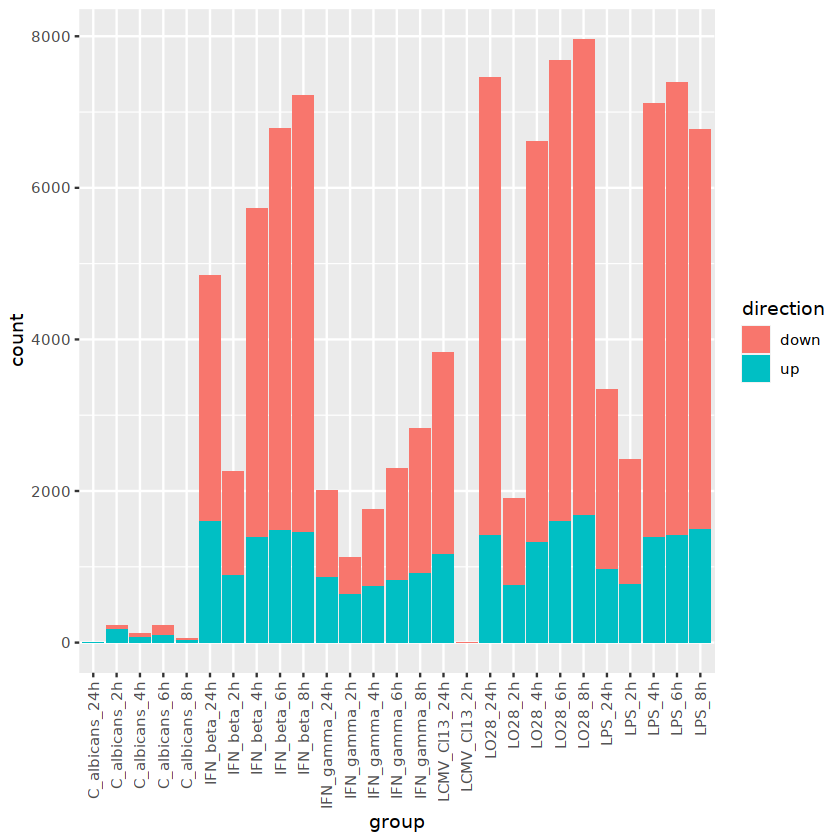

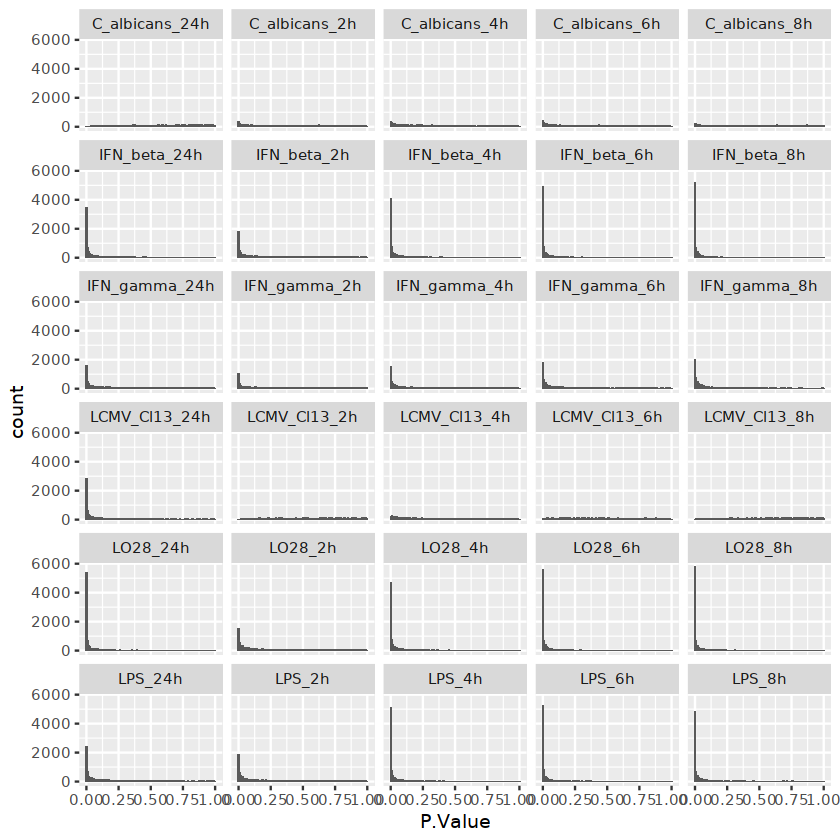

[1] "Enrichment of list: C_albicans_24h up"
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: C_albicans_2h down"
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
[1] "Enrichment of list: C_albicans_2h up"
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
  Querying NCI-Nature_2016... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying Panther_2016... Done.
  Querying BioCarta_2016... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done

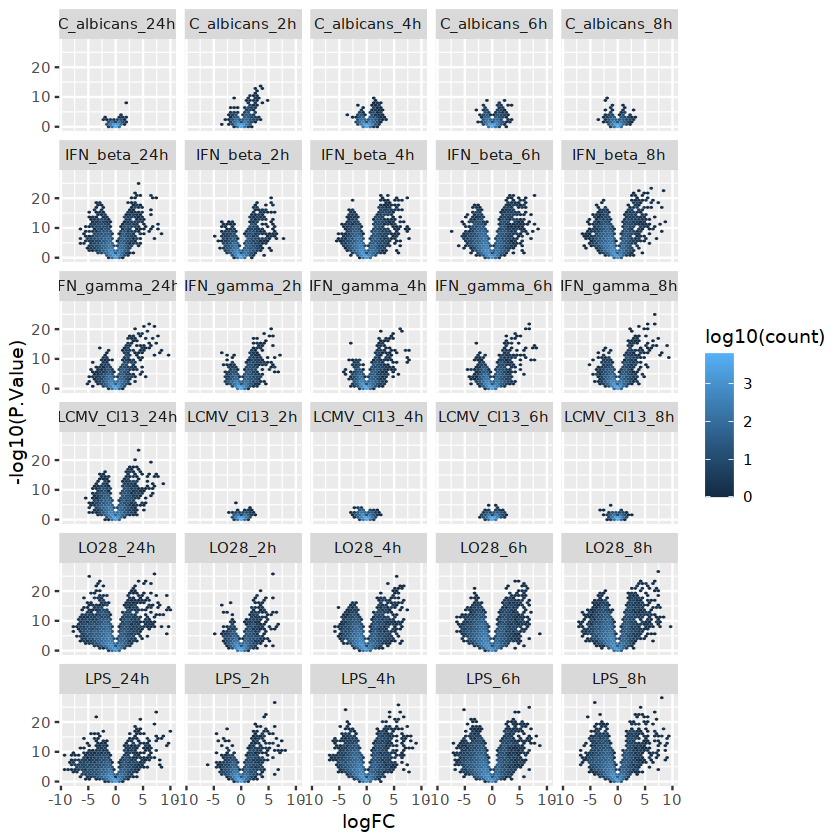

In [20]:
# Significant hits and Enrichment -----------------------------------------
ggplot(res.sig, aes(x=group, fill=direction)) + geom_bar() + xRot()
ggsave(file.path(results_path,  "NumberOfHits.pdf"), w=10,h=5)

res.sig.genes.list <- lapply(with(res.sig, split(external_gene_name, paste(group, direction))), unique)
sapply(res.sig.genes.list, length)

# pvalue dist
ggplot(res[AveExpr > 1], aes(x=P.Value)) + geom_histogram(bins=100) + facet_wrap(~group, ncol=5)
ggsave(file.path(results_path,  "PvalueDistribution.pdf"), w=8,h=8)

# volcano plots
ggplot(res[AveExpr > 1], aes(x=logFC, y=-log10(P.Value))) + stat_binhex(aes(fill=log10(..count..))) + facet_wrap(~group, ncol=5)
ggsave(file.path(results_path,  "VolcanoPlots.pdf"), w=8,h=8)

# Enrichr
enr <- enrichGeneList.oddsRatio.list(
  geneLists=res.sig.genes.list,
  enrichrDBs=c("BioPlanet_2019", "KEGG_2019_Mouse", "NCI-Nature_2016", "WikiPathways_2019_Mouse", "Panther_2016", "BioCarta_2016", "GO_Biological_Process_2021"))
enrichr.plot.many(enrichRes=enr, out=file.path(paste0(results_path,"/")), label="Enrichr_")